# Import necessary Libraries

In [4]:
# Install pyreadr to read R-Files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Read the data belonging to Normal condition

In [5]:
df_FaultFree = pd.read_csv(r'Dataset/Healthy.csv')
df_FaultFree.head()

faultNumber  simulationRun  sample  xmeas_1  xmeas_2  xmeas_3  xmeas_4  \
0          0.0            1.0       1  0.25038   3674.0   4529.0   9.2320   
1          0.0            1.0       2  0.25109   3659.4   4556.6   9.4264   
2          0.0            1.0       3  0.25038   3660.3   4477.8   9.4426   
3          0.0            1.0       4  0.24977   3661.3   4512.1   9.4776   
4          0.0            1.0       5  0.29405   3679.0   4497.0   9.3381   

   xmeas_5  xmeas_6  xmeas_7  ...   xmv_2   xmv_3   xmv_4   xmv_5   xmv_6  \
0   26.889   42.402   2704.3  ...  53.744  24.657  62.544  22.137  39.935   
1   26.721   42.576   2705.0  ...  53.414  24.588  59.259  22.084  40.176   
2   26.875   42.070   2706.2  ...  54.357  24.666  61.275  22.380  40.244   
3   26.758   42.063   2707.2  ...  53.946  24.725  59.856  22.277  40.257   
4   26.889   42.650   2705.1  ...  53.658  28.797  60.717  21.947  39.144   

    xmv_7   xmv_8   xmv_9  xmv_10  xmv_11  
0  42.323  47.757  47.510  41.258  18.447  
1  38.554  43.692  47.427  41.359  17.194  
2  38.990  46.699  47.468  41.199  20.530  
3  38.072  47.541  47.658  41.643  18.089  
4  41.955  47.645  47.346  41.507  18.461  

[5 rows x 55 columns]

# Do a train-test split for training Auto encoder

In [6]:
X_train  = df_FaultFree[df_FaultFree ['simulationRun']<5].iloc[:,3:]

X_test = df_FaultFree[df_FaultFree ['simulationRun']==5].iloc[:,3:]

# Normalize the data to bring all the variables to a similar range (required for faster optimization of gradient descent)

In [7]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

# Save the scaler to a file. It will be used during inference.
joblib.dump(scaler, 'standard_scaler.pkl')

['standard_scaler.pkl']

# Training an AutoEncoder

In [8]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Define input layer
input_layer = Input(shape=(X_train_sc.shape[1],))

# Define encoder layers
encoded = Dense(100, activation='relu')(input_layer)

# Define decoder layers
decoded = Dense(100, activation='relu')(encoded)
decoded = Dense(X_train_sc.shape[1], activation='linear')(decoded)

# Define autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile autoencoder model
autoencoder.compile(optimizer='adam', loss='mse')

# Print model summary
autoencoder.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 52)]              0         
                                                                 
 dense (Dense)               (None, 100)               5300      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 52)                5252      
                                                                 
Total params: 20652 (80.67 KB)
Trainable params: 20652 (80.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/300

16/16 [==============================] - 1s 12ms/step - loss: 0.9896 - val_loss: 0.8064
Epoch 2/300
16/16 [==============================] - 0s 4ms/step - loss: 0.7635 - val_loss: 0.6503
Epoch 3/300
16/16 [==============================] - 0s 3ms/step - loss: 0.5983 - val_loss: 0.5273
Epoch 4/300
16/16 [==============================] - 0s 4ms/step - loss: 0.4743 - val_loss: 0.4303
Epoch 5/300
16/16 [==============================] - 0s 3ms/step - loss: 0.3805 - val_loss: 0.3538
Epoch 6/300
16/16 [==============================] - 0s 3ms/step - loss: 0.3087 - val_loss: 0.2934
Epoch 7/300
16/16 [==============================] - 0s 3ms/step - loss: 0.2553 - val_loss: 0.2488
Epoch 8/300
16/16 [==============================] - 0s 3ms/step - loss: 0.2146 - val_loss: 0.2144
Epoch 9/300
16/16 [==============================] - 0s 3ms/step - loss: 0.1836 - val_loss: 0.1857
Epoch 10/300
16/16 [==============================] - 0s 4ms/step - loss: 0.1593 - val_loss: 0.1657
Epoch 1

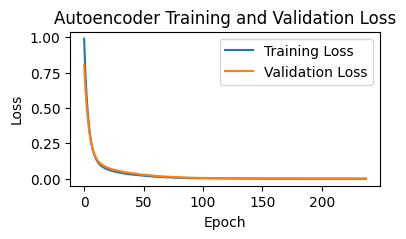

c:\Users\Administrator\miniconda3\envs\TEP_deployment\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
# Define early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

# Fit autoencoder model with early stopping callback
history = autoencoder.fit(X_train_sc, X_train_sc,
                epochs=300,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test_sc, X_test_sc),
                callbacks=[early_stopping_callback])

plt.rcParams['figure.figsize'] = [4, 2]
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the trained model
autoencoder.save("autoencoder_model.h5")

## Load the trained NN model

In [10]:
from tensorflow.keras.models import load_model

# Load the saved autoencoder model
loaded_autoencoder = load_model("autoencoder_model.h5")

# Reconstruction on Normal Data

16/16 [==============================] - 0s 818us/step


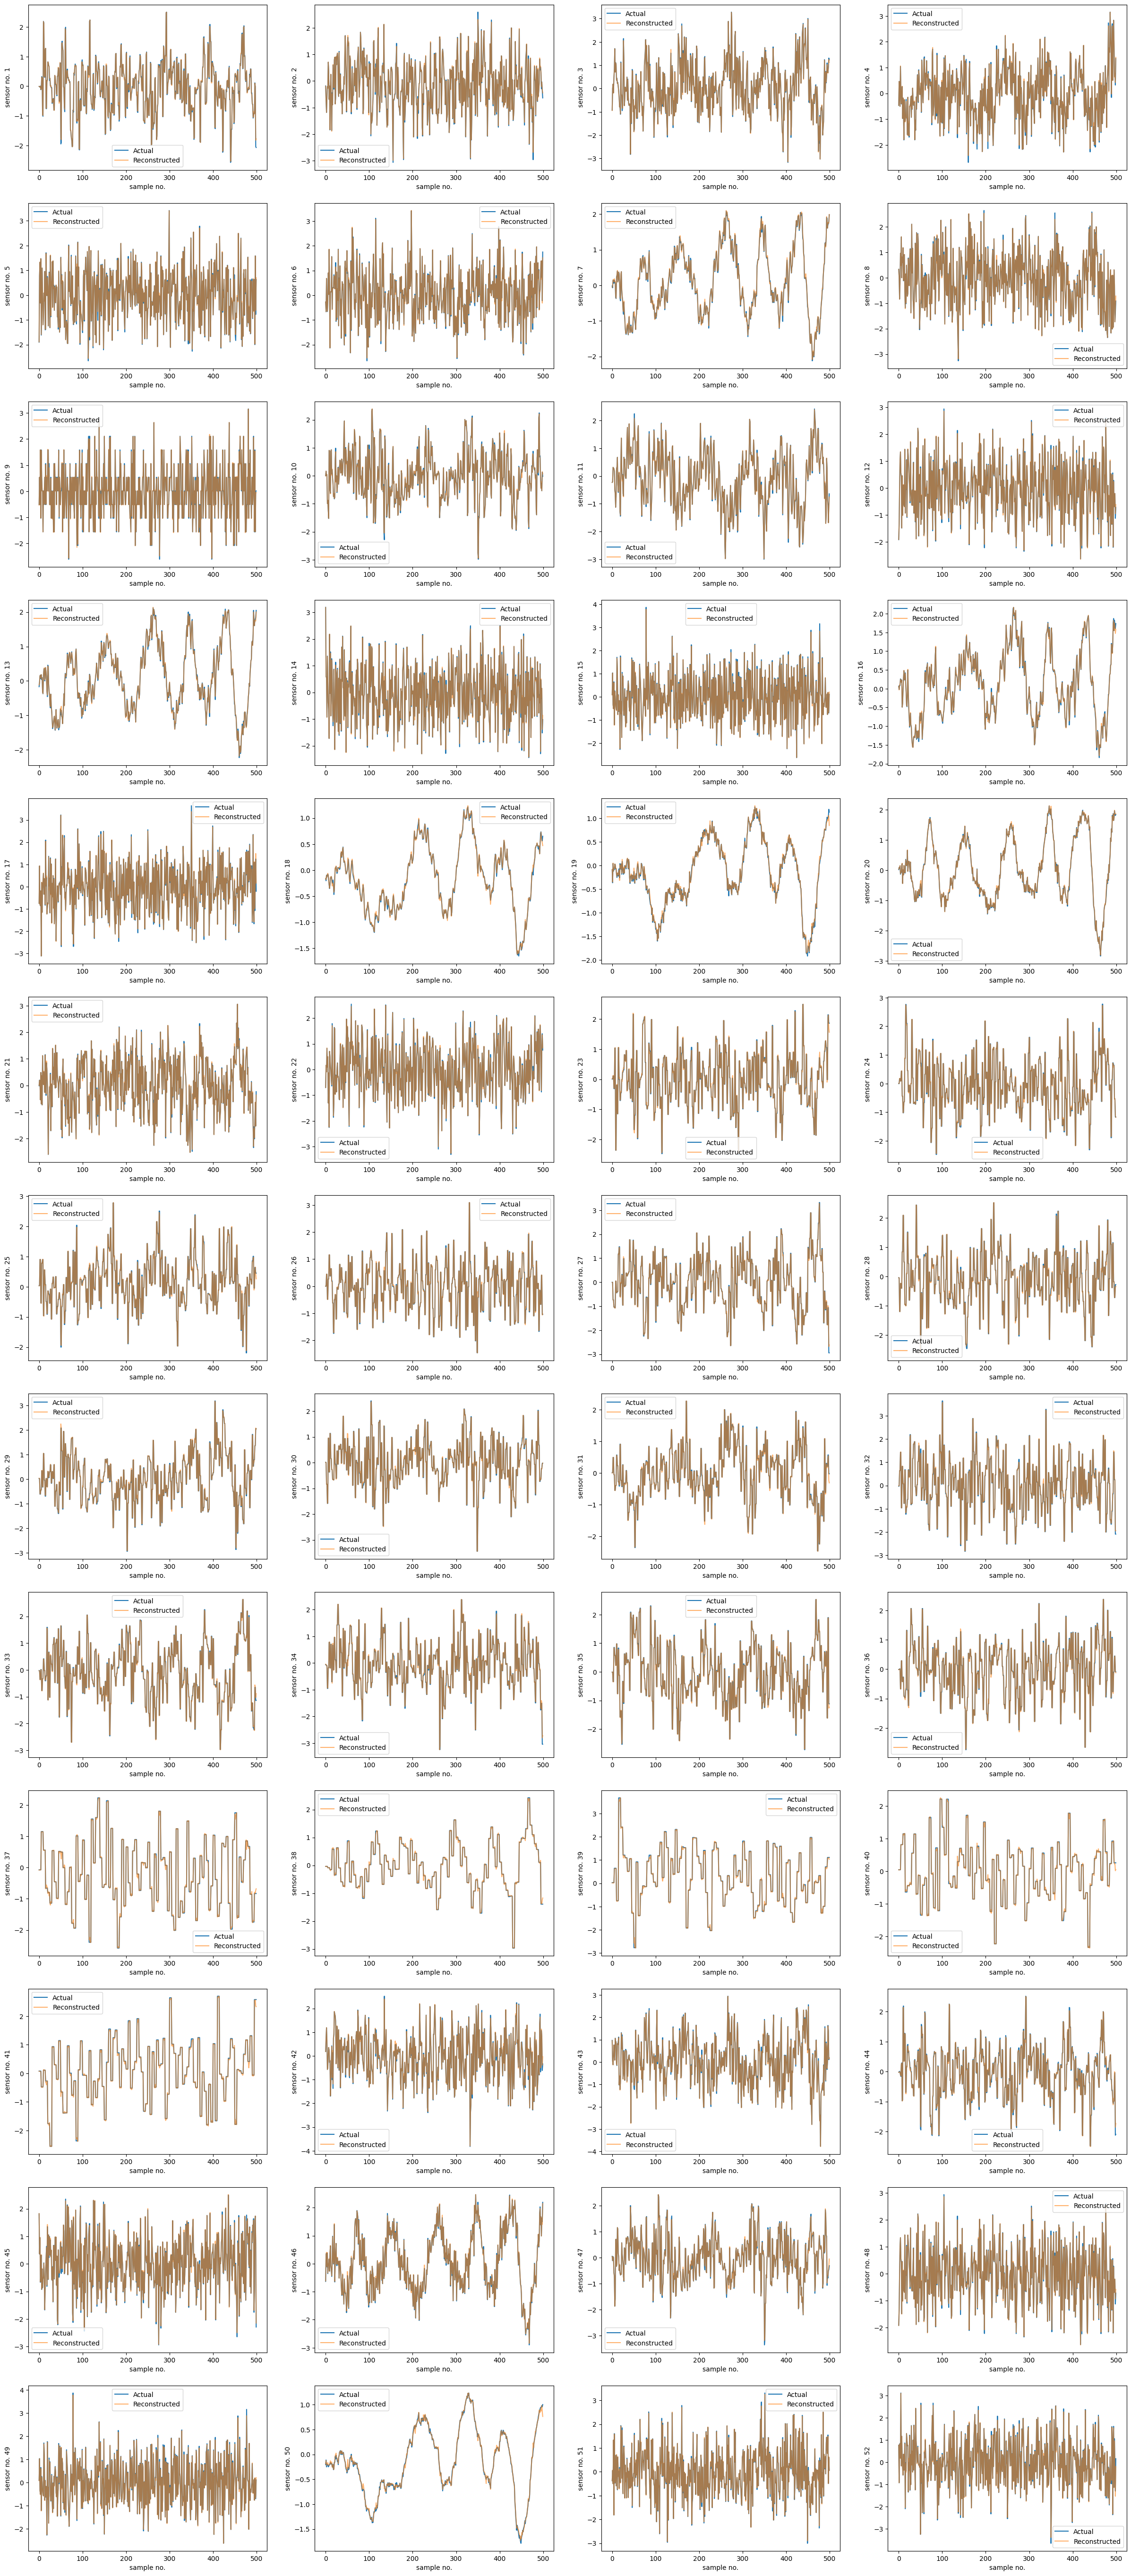

In [11]:
X_test_recon = loaded_autoencoder.predict(X_test_sc)

fig, ax = plt.subplots(13,4,figsize=(30,70))

for i in range (0,X_test_sc.shape[1]):  #select all the feature columns to plot
    ax.ravel()[i].plot(X_test_sc[:,i],label='Actual')
    ax.ravel()[i].plot(X_test_recon[:,i],label='Reconstructed',alpha=0.6)
    ax.ravel()[i].set_xlabel('sample no.')
    ax.ravel()[i].set_ylabel(f'sensor no. {i+1}')
    ax.ravel()[i].legend()

# Reconstruction on Faulty Data

16/16 [==============================] - 0s 1ms/step


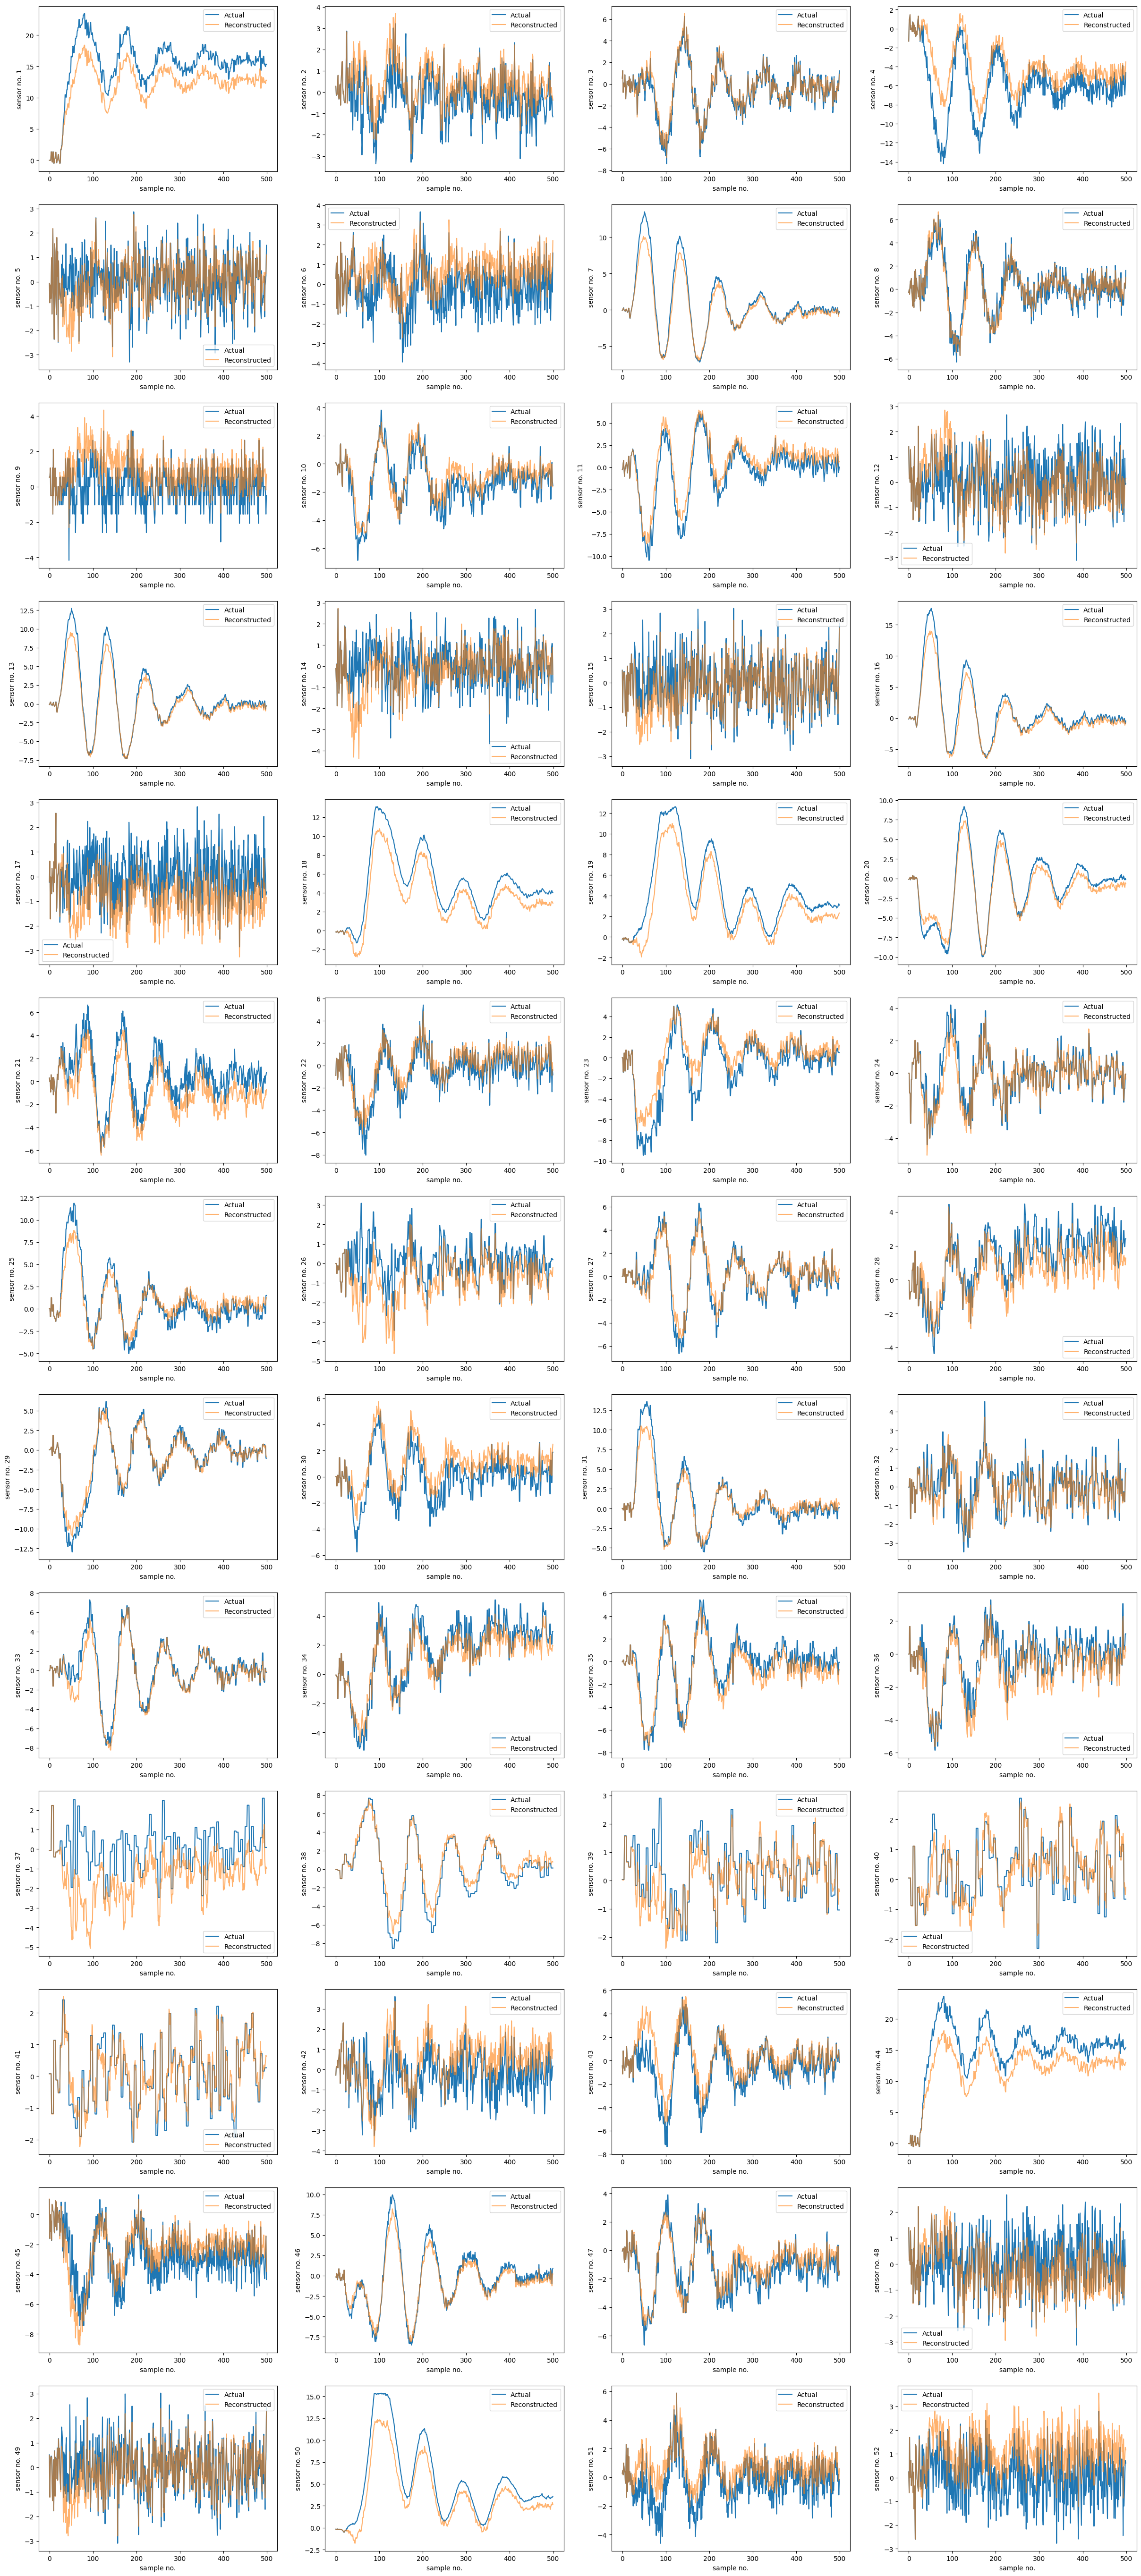

In [12]:
test_df = pd.read_csv(r'Dataset/Fault_1.csv')
test_sc = scaler.transform(test_df.iloc[:,3:])

recon = autoencoder.predict(test_sc)

fig, ax = plt.subplots(13,4,figsize=(30,70))

for i in range (0,test_sc.shape[1]):  #select all the feature columns to plot
    ax.ravel()[i].plot(test_sc[:,i],label='Actual')
    ax.ravel()[i].plot(recon[:,i],label='Reconstructed',alpha=0.6)
    ax.ravel()[i].set_xlabel('sample no.')
    ax.ravel()[i].set_ylabel(f'sensor no. {i+1}')
    ax.ravel()[i].legend()

# Estimating the Reconstruction Loss

In [13]:
def recon_loss(NN,X):
    #NN is the trained neural network model
    X_pred = NN.predict(X)
    reconstruction_loss = np.mean((X-X_pred)**2,axis=1)
    return reconstruction_loss

### As seen in the below figure, the distribution of the reconstruction loss for Faultfree condition is very small which the reconstruction for Faulty case is very high.

 1/16 [>.............................] - ETA: 0s

16/16 [==============================] - 0s 1ms/step


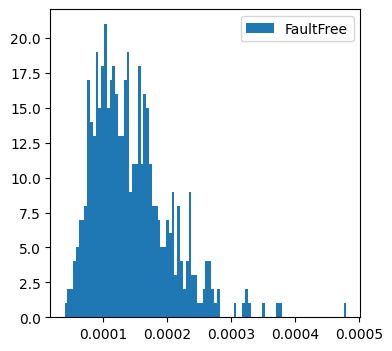

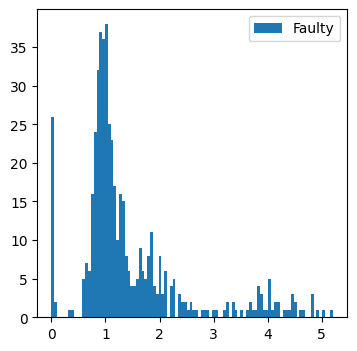

In [14]:
X_faultFree = X_train_sc[:500,:]
FaultFree_reconstruction_loss=recon_loss(NN=autoencoder,X=X_faultFree)

test_df = pd.read_csv(r'Dataset/Fault_1.csv')
test_sc = scaler.transform(test_df.iloc[:,3:])
Faulty_reconstruction_loss=recon_loss(NN=autoencoder,X=test_sc)

plt.rcParams['figure.figsize'] = [4, 4]
plt.hist(FaultFree_reconstruction_loss, bins=100,label='FaultFree',alpha=1)
# plt.xlim([0,0.001])
plt.legend()
plt.show()

plt.rcParams['figure.figsize'] = [4, 4]
plt.hist(Faulty_reconstruction_loss, bins=100,label='Faulty',alpha=1)
# plt.xlim([0,0.001])
plt.legend()
plt.show()

# Using ReconLoss for monitoring

16/16 [==============================] - 0s 760us/step


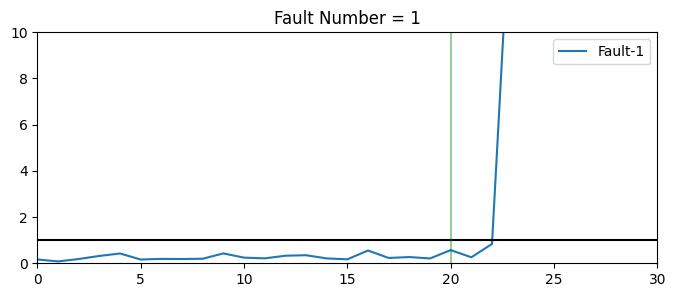

In [15]:
threshold=0.0005

F_num = 1 #{1,2,4,6}

test_df = pd.read_csv(rf'Dataset/Fault_{F_num}.csv')
test_sc = scaler.transform(test_df.iloc[:,3:])
Faulty_reconstruction_loss=recon_loss(NN=autoencoder,X=test_sc)/threshold

plt.rcParams['figure.figsize'] = [8,3]
plt.plot(Faulty_reconstruction_loss,label=f'Fault-{F_num}')
plt.axhline(1,c='k')    #threshold value
plt.axvline(20,c='g',alpha=0.4) #time of fault introduction
plt.title(f'Fault Number = {F_num}')

plt.xlim([0,30])
plt.ylim([0,10])
plt.legend()
plt.show()

# Using ReconLoss for feature Importance

In [16]:
test_df = pd.read_csv(r'Dataset/Healthy.csv')
test_sc = scaler.transform(test_df.iloc[:,3:])

recon = autoencoder.predict(test_sc)

diff = np.abs(test_sc-recon)
feature_wise_threshold= np.max(diff,axis=0)

# Save the scaler to a file
joblib.dump(feature_wise_threshold, 'feature_wise_threshold.pkl')

79/79 [==============================] - 0s 942us/step


['feature_wise_threshold.pkl']

16/16 [==============================] - 0s 1ms/step


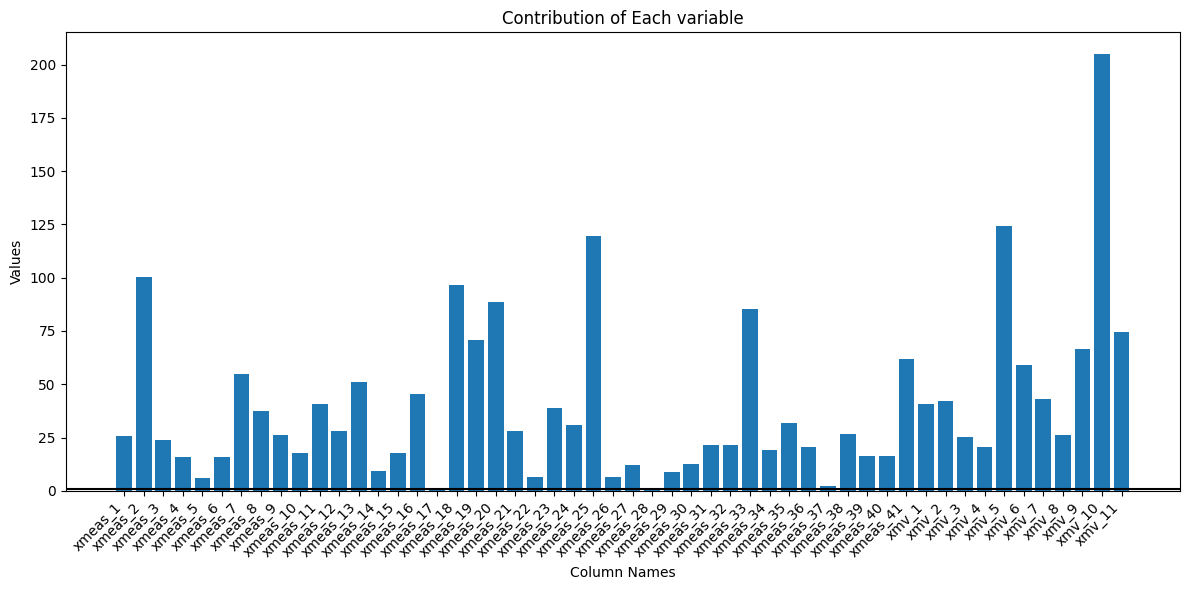

In [84]:
test_df = pd.read_csv(r'Dataset/Fault_6.csv')
test_sc = scaler.transform(test_df.iloc[:,3:])

recon = autoencoder.predict(test_sc)

Norm_diff = np.abs(test_sc-recon)/feature_wise_thresold

column_names = test_df.columns[3:]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(column_names, Norm_diff[300].ravel())  # Flatten the array to 1D for plotting
plt.axhline(1,c='k') # thresold for normal
plt.xlabel('Column Names')
plt.ylabel('Values')
plt.title('Contribution of Each variable')
plt.xticks(rotation=45, ha='right')  # Rotate x-tick labels for better visibility
plt.tight_layout()
plt.show()